In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### 데이터셋 출처
- retail rocket
- https://retailrocket.net/

In [2]:
# 출처: https://retailrocket.net/

path = 'C:/Users/Shiwon Kim/0_ML'

df = pd.read_csv(path + '/' + 'test6.csv')
df.shape

(2756101, 5)

In [3]:
df.head()

# timestamp -> UTC
# visitorid -> 방문자 정보
# event -> 고객의 행동패턴을 볼 수 있는 컬럼(구매의사 관련): view, addtocart, transaction
# itemid -> 상품 정보
# transactionid -> 결제 정보(NaN: 결제가 이루어지지 않은 경우 -> event=view/addtocart)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


#### Data Handling
- timestamp: datetime 형태로 변환

In [4]:
from datetime import datetime

sample = 1433221332117 # milisecond
parsed = datetime.utcfromtimestamp(sample / 1000) # milisecond 단위이므로 나누기 1000
parsed

datetime.datetime(2015, 6, 2, 5, 2, 12, 117000)

In [5]:
parsed.strftime('%Y-%m-%d %H:%M:%S')

'2015-06-02 05:02:12'

In [6]:
df['datetime'] = df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))
df.head()

,timestamp,visitorid,event,itemid,transactionid,datetime
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17


#### event/transactionid 확인
- 어떤 종류의 데이터가 있는지
- 결제가 이루어진(event=transaction) 상품은 모두 transactionid가 존재하는지

In [7]:
set(df['event'])

# view -> 상세 페이지 조회
# addtocart -> 장바구니에 추가
# transaction -> 상품 구매(결제)

# 의사결정 과정: view -> addtocart -> transaction
# visitor의 item에 대한 관심도를 다르게 적용

{'addtocart', 'transaction', 'view'}

In [8]:
df.loc[df['event'] == 'transaction']

,timestamp,visitorid,event,itemid,transactionid,datetime
130,1433222276276,599528,transaction,356475,4000.0,2015-06-02 05:17:56
304,1433193500981,121688,transaction,15335,11117.0,2015-06-01 21:18:20
418,1433193915008,552148,transaction,81345,5444.0,2015-06-01 21:25:15
814,1433176736375,102019,transaction,150318,13556.0,2015-06-01 16:38:56
843,1433174518180,189384,transaction,310791,7244.0,2015-06-01 16:01:58
...,...,...,...,...,...,...
2755294,1438377176570,1050575,transaction,31640,8354.0,2015-07-31 21:12:56
2755349,1438379878779,861299,transaction,456602,3643.0,2015-07-31 21:57:58
2755508,1438357730123,855941,transaction,235771,4385.0,2015-07-31 15:48:50
2755603,1438355560300,548772,transaction,29167,13872.0,2015-07-31 15:12:40


## Buying Journey
1. 고객 진입
2. 상품 제시(impression)
3. 상품 선택
4. 상세 페이지 이동
5. 관심 상품 장바구니 이동
6. 결제 페이지 이동
7. 결제 실행

#### 고객과 상품 간의 연결고리
- 관심의 정도/연결고리의 강도를 수치화
    - 상품을 클릭한 경우(view)
    - 장바구니에 담은 경우(addtocart)
    - 결제한 경우(transaction)

In [9]:
len(set(df['visitorid']))

# 고객 140.7만 명 정도

1407580

In [10]:
len(set(df['itemid']))

# 상품 23.5만 개 정도

235061

In [11]:
# event를 각각 1, 2, 3으로 수치화
intention = {'view':1, 'addtocart':2, 'transaction':3}
df['intention'] = df['event'].map(intention)
df.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,intention
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12,1
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14,1
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19,1
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35,1
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17,1


In [12]:
# 관심도가 높은 고객/상품을 위주로 추출하기 위한 cf(협업 필터링) set 생성
cf_set = df.groupby(['visitorid', 'itemid']).agg({'intention':np.sum}).reset_index()
cf_set

,visitorid,itemid,intention
0,0,67045,1
1,0,285930,1
2,0,357564,1
3,1,72028,1
4,2,216305,2
...,...,...,...
2145174,1407575,121220,1
2145175,1407576,356208,1
2145176,1407577,427784,1
2145177,1407578,188736,1


In [13]:
# 상품에 대한 관심도를 수치화한 intention 점수를 기준으로 고객 정렬
user_group = cf_set.groupby('visitorid').agg(
    {'intention':np.sum}).sort_values(by='intention').reset_index()
user_group

,visitorid,intention
0,703789,1
1,858794,1
2,858798,1
3,858800,1
4,858801,1
...,...,...
1407575,163561,2718
1407576,684514,2855
1407577,152963,4093
1407578,530559,5319


<AxesSubplot:>

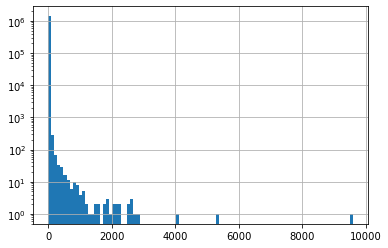

In [14]:
user_group['intention'].hist(bins=100, log=True)

# 대부분의 고객들은 대체적으로 구매 의사가 낮고,
# 일부 소수 고객만 매우 높은 구매 의사 보유 -> 파레토 분포

In [15]:
# 관심도 상위 5명 고객 추출
user_group.sort_values(by='intention').tail()

,visitorid,intention
1407575,163561,2718
1407576,684514,2855
1407577,152963,4093
1407578,530559,5319
1407579,1150086,9594


#### 관심도 상위 고객 데이터 확인
- 행위(event)의 종류
- 실구매 건수
- 구매 상품 id

In [19]:
user = 1150086
heavy_user = df.loc[df['visitorid'] == user].sort_values(by='timestamp')

columns = ['itemid', 'event', 'datetime']
heavy_user[columns]

# intention 1위 고객은 7757건의 행위(7757 rows)를 한 헤비 유저
# 그런데 intention=9594 > 7757인 것으로 보아 view 외에 addtocart, transaction 행위도 많이 한 고객
# 따라서 해당 사이트에 관심이 아주 많은 고객

,itemid,event,datetime
230843,133542,view,2015-06-11 14:55:17
240552,167873,view,2015-06-11 15:15:35
243885,231726,view,2015-06-11 15:20:06
229405,427777,view,2015-06-11 15:24:48
243973,398115,view,2015-06-11 15:25:32
...,...,...,...
1446226,157621,view,2015-09-17 02:42:14
1450199,25383,view,2015-09-17 02:42:27
1446175,270534,view,2015-09-17 02:49:47
1446187,406727,view,2015-09-17 02:56:06


In [20]:
# heavy_user 데이터 중 최종 구매로 이어진 정보를 확인
heavy_trans = heavy_user.loc[heavy_user['event'] == 'transaction']
heavy_trans[interested]

# 세 달 정도의 짧은 시간 동안 실구매 559건 -> VIP 고객
# 짧은 기간에 집중적으로 많은 구매를 한 것으로 보아 도매업 종사자로 추정

,itemid,event,datetime
237133,398115,transaction,2015-06-11 15:28:45
230745,375955,transaction,2015-06-11 15:42:28
243864,357133,transaction,2015-06-11 15:46:36
236873,310620,transaction,2015-06-11 21:42:58
239981,276704,transaction,2015-06-11 21:42:58
...,...,...,...
1446963,359910,transaction,2015-09-16 17:14:56
1445133,340825,transaction,2015-09-16 17:53:22
1449591,99601,transaction,2015-09-16 18:27:51
1445449,406727,transaction,2015-09-16 19:32:50


In [21]:
# 재구매 상품 확인
pd.DataFrame(heavy_trans['itemid'].value_counts())

,itemid
310944,3
248455,3
166306,3
424506,2
384302,2
...,...
107025,1
109498,1
436034,1
127631,1


#### 웹 크롤링이나 매크로 프로그램을 활용한 구매
- 아주 짧은 시간 동안 특정 행위를 반복적으로 취하는 경우
- 행위(event)가 규칙적인 패턴을 보이는 경우
- 시간(datetime) 정보를 활용하여 일반 구매와 매크로 구분
    - ex) view에서 addtocart, addtocart에서 transaction으로 넘어가는 시간이 지나치게 짧은 경우
    - 일반 구매자라면 적어도 몇 초 이상의 간격은 존재할 것이라고 판단